In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np
import pymc4 as pm
import seaborn as sns
import arviz as az

In [16]:
def array(*args, **kwargs):
    kwargs.setdefault("dtype", np.float32)
    return np.array(*args, **kwargs)

In [17]:
N = 1000
W = array([0.35, 0.4, 0.25])
MU = array([0., 2., 5.])
SIGMA = array([0.5, 0.5, 1.])

In [18]:
component = np.random.choice(MU.size, size=N, p=W)
x = np.random.normal(MU[component], SIGMA[component], size=N)

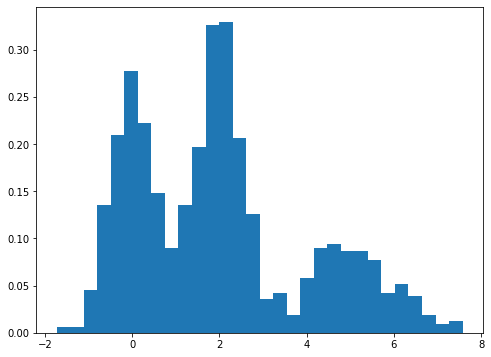

In [19]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(x, bins=30, density=True, lw=0);

In [30]:
@pm.model                                                                                                       
def model():
    w = yield pm.Dirichlet("w", [1, 1, 1], transform=pm.transforms.Invert(pm.transforms.SoftmaxCentered()))
    mu = yield pm.Normal("mu", [0., 0., 0.], 10.)
    tau = yield pm.Normal("tau", [1., 1., 1.], 1.)                                                                                          
    x_obs = yield pm.NormalMixture("x_obs", w, mu, tau, observed=x)
    return x_obs

In [31]:
trace, stat = pm.sample(model(), num_chains=2, num_samples=3000, burn_in=200, xla=True)

In [32]:
az_trace = pm.trace_to_arviz(trace, stat)
az.summary(az_trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
model/mu[0],2.519,2.504,-0.052,5.133,1.768,1.497,2.0,2.0,3.0,54.0,1.83
model/mu[1],2.521,2.504,-0.055,5.135,1.768,1.497,2.0,2.0,3.0,49.0,1.83
model/mu[2],1.993,0.033,1.933,2.056,0.000,0.000,6699.0,6695.0,6712.0,5018.0,1.00
model/tau[0],0.771,0.250,0.468,1.101,0.174,0.146,2.0,2.0,3.0,48.0,1.83
model/tau[1],0.771,0.249,0.467,1.099,0.173,0.145,2.0,2.0,3.0,47.0,1.83
model/tau[2],0.507,0.031,0.448,0.564,0.001,0.000,3690.0,3658.0,3740.0,4661.0,1.00
model/__Invert_w[0],-0.386,0.228,-0.742,-0.041,0.150,0.123,2.0,2.0,3.0,56.0,1.82
model/__Invert_w[1],-0.388,0.228,-0.730,-0.027,0.150,0.123,2.0,2.0,3.0,50.0,1.82
model/w[0],0.291,0.062,0.208,0.376,0.042,0.035,2.0,2.0,3.0,64.0,1.83
model/w[1],0.290,0.062,0.208,0.375,0.042,0.035,2.0,2.0,3.0,46.0,1.83


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fca141fc2b0>,
      dtype=object)

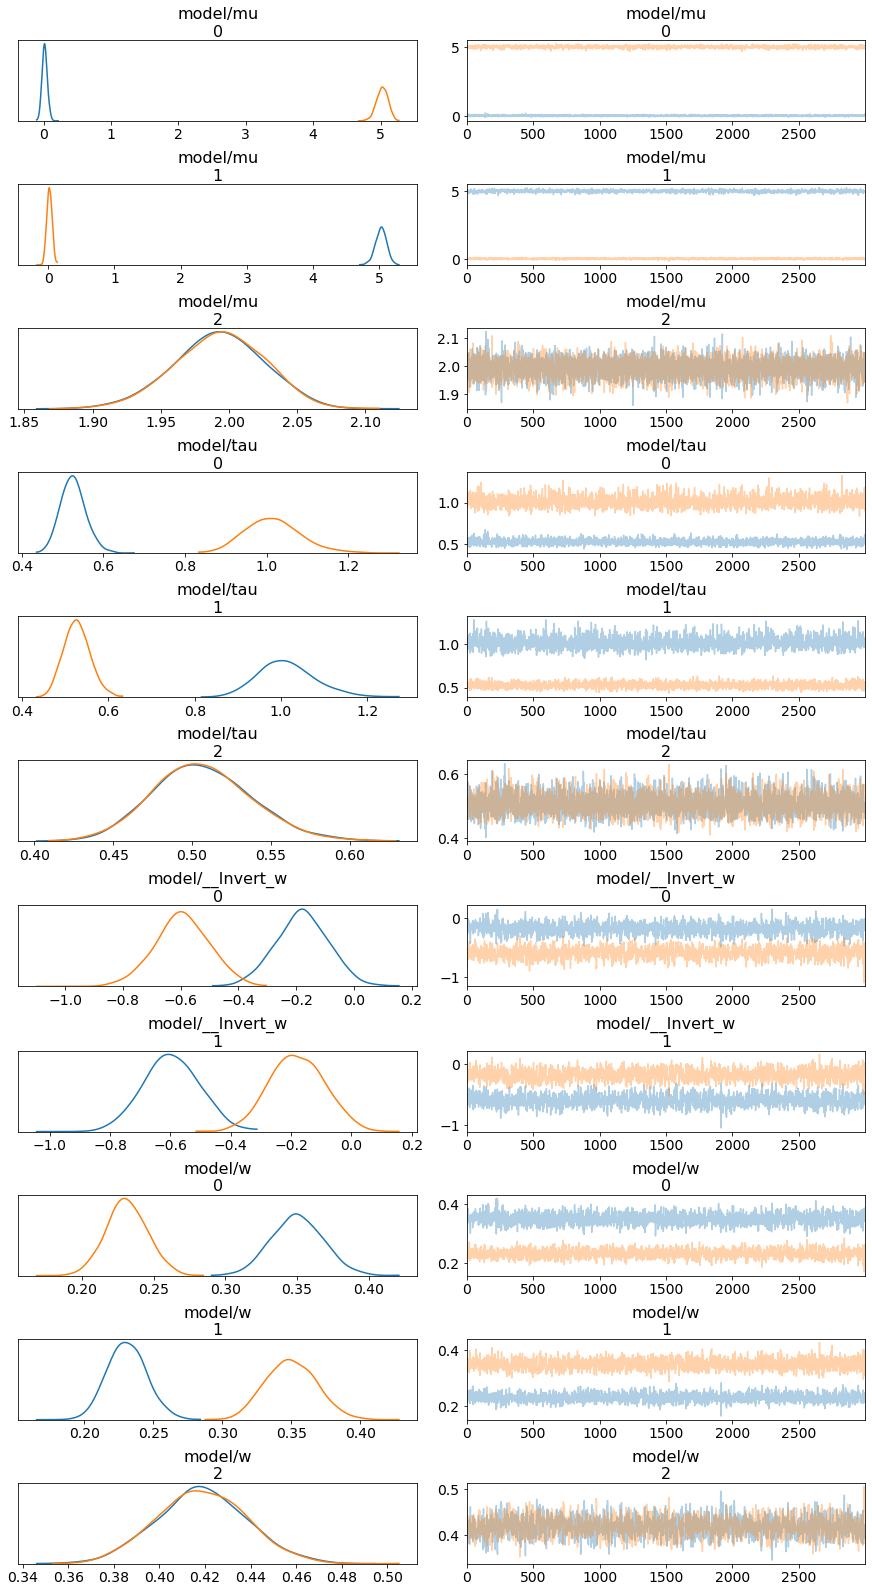

In [33]:
az.plot_trace(az_trace)

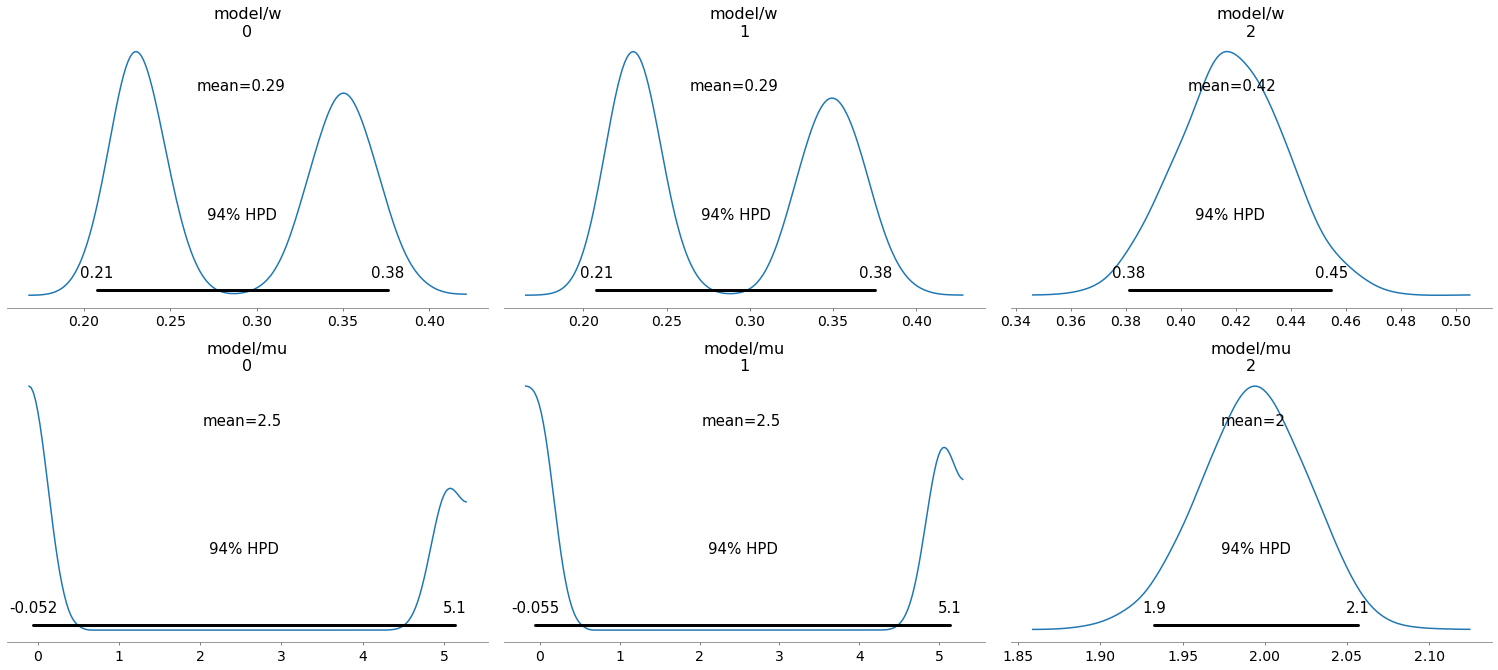

In [34]:
az.plot_posterior(az_trace, var_names=['model/w', 'model/mu']);

In [62]:
ppc_trace = pm.sample_posterior_predictive(model(), trace, var_names={"model/x_obs"})
ppc_trace['model/x_obs'] = ppc_trace['model/x_obs'][:,0,:] # should maybe take mean from both chains, not clear

W0115 15:57:32.572168 140508583712576 pfor.py:2796] Note that Multinomial inside pfor op may not give same output as inside a sequential loop.
W0115 15:57:32.618959 140508583712576 pfor.py:2751] Note that RandomStandardNormal inside pfor op may not give same output as inside a sequential loop.


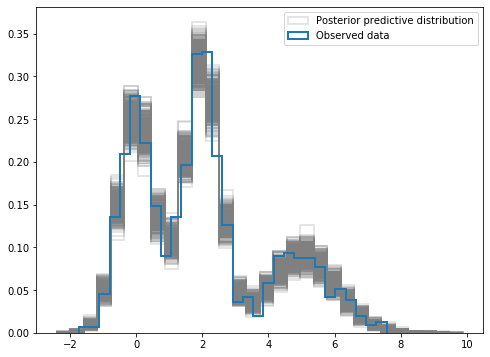

In [63]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(ppc_trace['model/x_obs'], bins=30, density=True,
        histtype='step', lw=2,
        color=['.5'] * ppc_trace['model/x_obs'].shape[1],
        alpha=.2,
        label='Posterior predictive distribution');

ax.hist(x, bins=30, density=True,
        histtype='step', lw=2,
        label='Observed data');

ax.legend(loc=1);